In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data preproccessing

In [2]:
df = pd.read_csv('US_Accidents_March23.csv')

In [3]:
df = df.drop_duplicates()

In [4]:
df.shape

(7728394, 46)

In [5]:
df.isnull().sum()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

Fill missing values

In [6]:
df = df[df['Severity'].between(1, 4)]

In [7]:
df.loc[(df['End_Lat'].isna()) & (df['Distance(mi)'] == 0), 'End_Lat'] = df['Start_Lat']
df.loc[(df['End_Lng'].isna()) & (df['Distance(mi)'] == 0), 'End_Lng'] = df['Start_Lng']

In [8]:
df['End_Lat'] = df.groupby('State')['End_Lat'].transform(
    lambda x: x.fillna(x.median()))
df['End_Lng'] = df.groupby('State')['End_Lng'].transform(
    lambda x: x.fillna(x.median()))

In [9]:
numeric_features = [
    'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
]
for feature in numeric_features:
    df[feature] = df.groupby('State')[feature].transform(
        lambda x: x.fillna(x.median()))

In [10]:
categorical_features = [
    'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
    'Source', 'Timezone', 'Airport_Code', 'Street',
    'City', 'County', 'Zipcode', 'Country'
]
for feature in categorical_features:
    df[feature] = df.groupby('State')[feature].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [11]:
df['Description'] = df['Description'].fillna('No description provided')

In [12]:
poi_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]
for feature in poi_features:
    df[feature] = df[feature].fillna(False).astype(bool)

In [13]:
time_cols = ['Start_Time', 'End_Time', 'Weather_Timestamp']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
    if col == 'Weather_Timestamp':
        df[col] = df[col].fillna(df['Start_Time'])
    df = df.dropna(subset=[col])


Calculate columns: speed, year, mounth, duration_h, check that dictance is non-negative

In [ ]:
df['Duration_min'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
df['Duration_h'] = df['Duration_min'] / 60
df['Hour'] = df['Start_Time'].dt.hour
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Speed'] = df['Distance(mi)'] / df['Duration_h']

df = df[df['Duration_min'] >= 0]
df = df[df['Distance(mi)'] >= 0]

In [16]:
df.isnull().sum()

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Description              0
Street                   0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
S

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


do binning

In [18]:
df['Temp_Bin'] = pd.cut(df['Temperature(F)'], bins=5, labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot'])
df['Wind_Speed_Bin'] = pd.cut(df['Wind_Speed(mph)'], bins=5, labels=['Calm', 'Light', 'Moderate', 'Strong', 'Very Strong'])
df = pd.get_dummies(df, columns=['Temp_Bin', 'Wind_Speed_Bin'], drop_first=True)

In [46]:
features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Speed(mph)', 
            'Weather_Condition', 'Wind_Direction', 'Hour', 'Month', 'Duration_min']
X = df[features]
y = df['Severity']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Visualise distribution between classes

/var/folders/jf/dhkds2b17t9dzk4rsbq0_w1h0000gn/T/ipykernel_73736/3781379303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette='viridis')


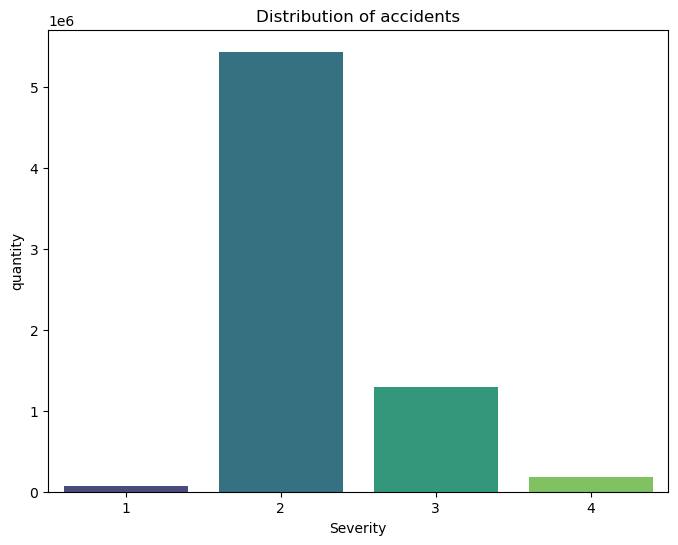

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Severity', data=df, palette='viridis')
plt.title('Distribution of accidents')
plt.xlabel('Severity')
plt.ylabel('quantity')
plt.show()

so, we can see that 2hd classes the largest amount of rows

Visualise correlation between target and other features

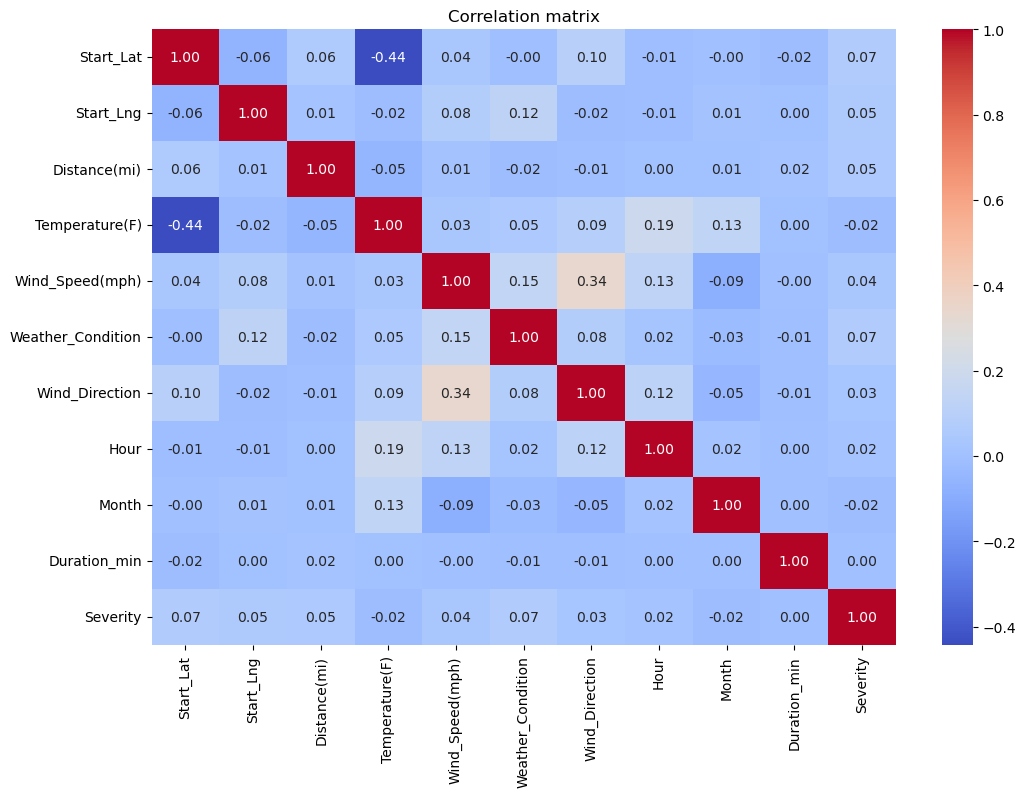

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[features + ['Severity']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

baseline: decisiontree, train it 

In [ ]:
dg_model = DecisionTreeClassifier(random_state=42)
dg_model.fit(X_train, y_train)
y_pred_dg = dg_model.predict(X_test)

In [23]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_dg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dg))

Accuracy: 0.8362

Classification Report:
              precision    recall  f1-score   support

           1       0.37      0.41      0.39     13410
           2       0.90      0.90      0.90   1087353
           3       0.66      0.67      0.66    259176
           4       0.36      0.38      0.37     37107

    accuracy                           0.84   1397046
   macro avg       0.57      0.59      0.58   1397046
weighted avg       0.84      0.84      0.84   1397046


Confusion Matrix:
[[  5500   6329   1435    146]
 [  7445 975022  84609  20277]
 [  1689  79313 173504   4670]
 [    93  18583   4224  14207]]


we can see that classes are inbalanced and try to do weighted loss, f1-score in 1sy and 4th classes are quite bad

In [27]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weights = {1: 100.0, 2: 1.0, 3: 2.0, 4: 100.0}
dg_model = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
dg_model.fit(X_train, y_train)
y_pred_dg = dg_model.predict(X_test)

In [28]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_dg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dg))

Accuracy: 0.8082

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.44      0.45     13410
           2       0.88      0.88      0.88   1087353
           3       0.58      0.58      0.58    259176
           4       0.36      0.38      0.37     37107

    accuracy                           0.81   1397046
   macro avg       0.57      0.57      0.57   1397046
weighted avg       0.81      0.81      0.81   1397046


Confusion Matrix:
[[  5847   5698   1725    140]
 [  5143 957945 103442  20823]
 [  1486 102550 151304   3836]
 [    81  18952   4145  13929]]


we can see that f1-score of 4th class is still too low
so i thought that it was noise, so we should check importances of features

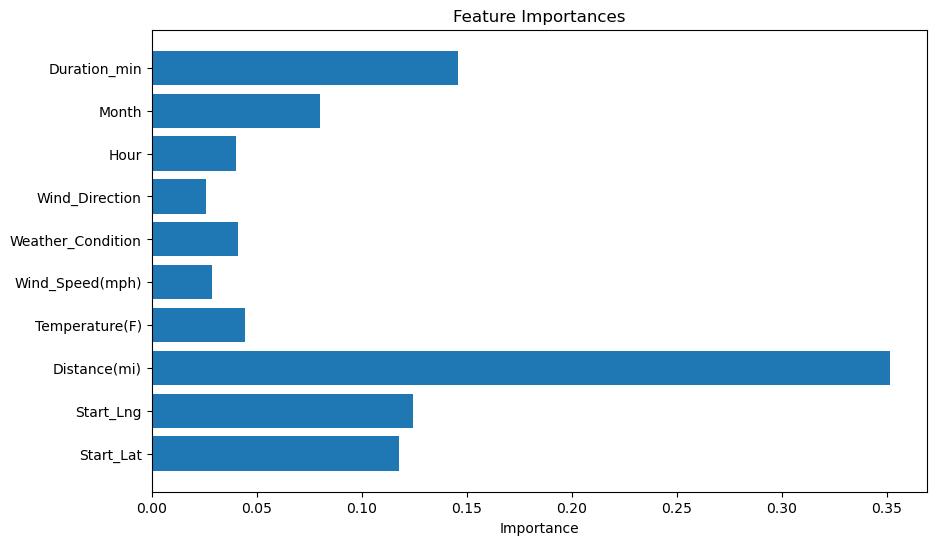

In [29]:
importances = dg_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Month', 'Duration_min', 'Speed']
X = df[features]
y = df['Severity']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

decisiontree + weighted loss + drop some features depending on its importance

In [32]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weights = {1: 100.0, 2: 1.0, 3: 2.0, 4: 100.0}
dg_model = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
dg_model.fit(X_train, y_train)
y_pred_dg = dg_model.predict(X_test)

In [33]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_dg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dg))

Accuracy: 0.8097

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.44      0.45      6710
           2       0.88      0.88      0.88    543439
           3       0.59      0.59      0.59    129887
           4       0.37      0.39      0.38     18487

    accuracy                           0.81    698523
   macro avg       0.58      0.57      0.58    698523
weighted avg       0.81      0.81      0.81    698523


Confusion Matrix:
[[  2933   2908    811     58]
 [  2565 479347  51159  10368]
 [   723  51224  76040   1900]
 [    39   9282   1907   7259]]


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np


binary_cols = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in [int, bool]]
numeric_cols = [col for col in X.columns if X[col].dtype in [np.float64, np.int64] and col not in binary_cols]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() < 1000]

high_cardinality = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() >= 1000]
if high_cardinality:
    print("Won't be encoded", high_cardinality)

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
    ]), categorical_cols)
], remainder='passthrough') 

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


df_mod = df.copy()

for col in ['Start_Time', 'End_Time', 'Weather_Timestamp']:
    if col in df_mod.columns:
        df_mod[col] = pd.to_datetime(df_mod[col], errors='coerce')

df_mod['start_hour'] = df_mod['Start_Time'].dt.hour
df_mod['start_dayofweek'] = df_mod['Start_Time'].dt.dayofweek
df_mod['start_month'] = df_mod['Start_Time'].dt.month

df_mod['duration_min'] = (df_mod['End_Time'] - df_mod['Start_Time']).dt.total_seconds() / 60

df_mod['weather_hour'] = df_mod['Weather_Timestamp'].dt.hour
df_mod['weather_month'] = df_mod['Weather_Timestamp'].dt.month

df_mod = df_mod.drop(columns=['Start_Time', 'End_Time', 'Weather_Timestamp'])

y = df_mod['Severity']
X = df_mod.drop(columns='Severity')

X_cleaned = X.select_dtypes(include=[np.number, 'bool'])

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, test_size=0.2, random_state=42, stratify=y
)

model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.64      0.65     13473
           2       0.91      0.91      0.91   1086776
           3       0.69      0.68      0.68    259851
           4       0.38      0.41      0.39     36946

    accuracy                           0.85   1397046
   macro avg       0.66      0.66      0.66   1397046
weighted avg       0.85      0.85      0.85   1397046



check all impotances

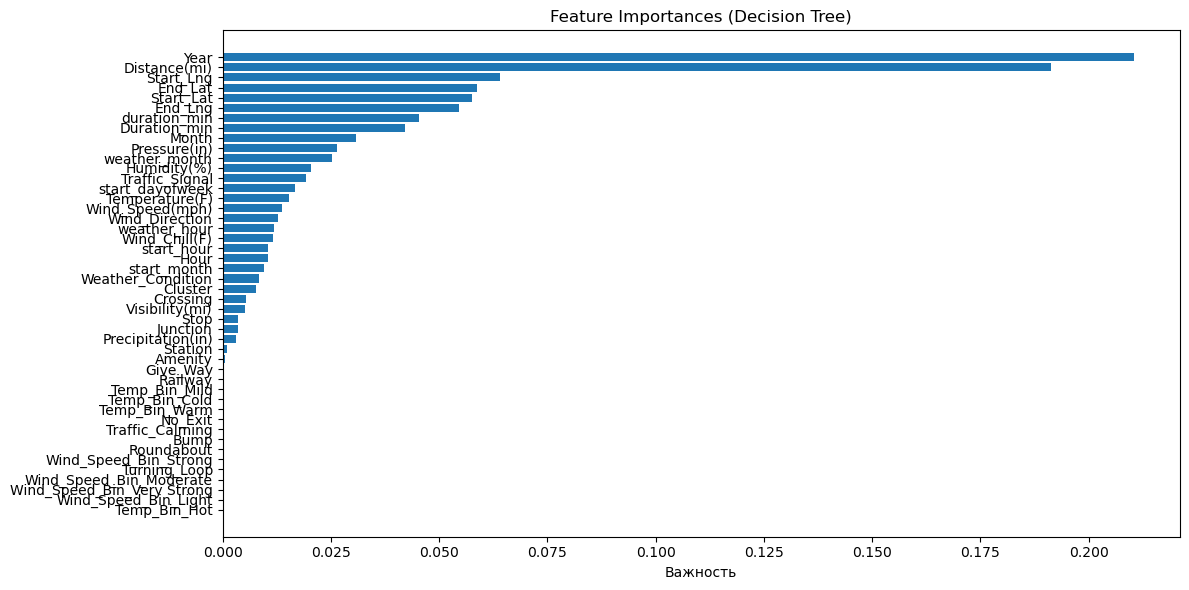

In [36]:
import matplotlib.pyplot as plt

importances = model.feature_importances_

feature_names = X_cleaned.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Decision Tree)")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Важность")
plt.tight_layout()
plt.show()

In [37]:
features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Year']
X = df[features]
y = df['Severity']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
class_weight = {1: 100.0, 2: 1.0, 3: 3.0, 4: 100.0}
dg_model = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
dg_model.fit(X_train, y_train)
y_pred_dg = dg_model.predict(X_test)

In [40]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_dg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dg))

Accuracy: 0.8617

Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.54      0.42     13410
           2       0.94      0.89      0.92   1087353
           3       0.72      0.81      0.76    259176
           4       0.30      0.40      0.34     37107

    accuracy                           0.86   1397046
   macro avg       0.57      0.66      0.61   1397046
weighted avg       0.88      0.86      0.87   1397046


Confusion Matrix:
[[  7211   5141    968     90]
 [ 11235 972699  76078  27341]
 [  2578  40102 209178   7318]
 [   167  17736   4519  14685]]


check train and test losses

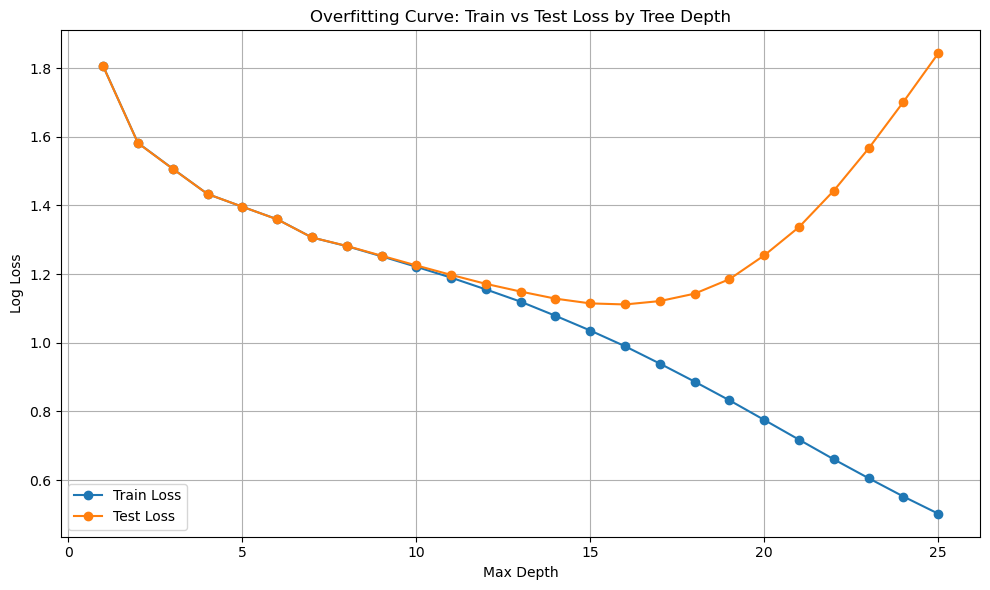

In [41]:
from sklearn.metrics import log_loss
train_losses = []
test_losses = []
depths = list(range(1, 26))  

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight=class_weights)
    model.fit(X_train, y_train)
    
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)
    
    train_loss = log_loss(y_train, y_train_proba)
    test_loss = log_loss(y_test, y_test_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)


plt.figure(figsize=(10, 6))
plt.plot(depths, train_losses, label='Train Loss', marker='o')
plt.plot(depths, test_losses, label='Test Loss', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Log Loss')
plt.title('Overfitting Curve: Train vs Test Loss by Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

max_depth = 15 for avoid overfitting

In [42]:
class_weight = {1: 100.0, 2: 1.0, 3: 3.0, 4: 100.0}
dg_model = DecisionTreeClassifier(random_state=42, class_weight=class_weight, max_depth = 15)
dg_model.fit(X_train, y_train)
y_pred_dg = dg_model.predict(X_test)

In [43]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_dg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dg))

Accuracy: 0.5343

Classification Report:
              precision    recall  f1-score   support

           1       0.12      0.92      0.21     13410
           2       0.93      0.50      0.65   1087353
           3       0.51      0.60      0.55    259176
           4       0.08      0.90      0.15     37107

    accuracy                           0.53   1397046
   macro avg       0.41      0.73      0.39   1397046
weighted avg       0.82      0.53      0.62   1397046


Confusion Matrix:
[[ 12322    384    335    369]
 [ 68725 546345 148725 323558]
 [ 21481  36490 154211  46994]
 [   553   2043    971  33540]]


implimentation of XGB

In [44]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier


df['Severity_adj'] = df['Severity'] - 1


n_per_class = 100000
balanced_parts = []

for label in df['Severity_adj'].unique():
    class_subset = df[df['Severity_adj'] == label]
    sampled = resample(
        class_subset,
        replace=True if len(class_subset) < n_per_class else False,
        n_samples=n_per_class,
        random_state=42
    )
    balanced_parts.append(sampled)


df_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)


X = df_balanced.drop(columns=['Severity', 'Severity_adj'])
y = df_balanced['Severity_adj']


X = X.drop(columns=X.select_dtypes(include=['object', 'datetime64[ns]']).columns)
X = X.select_dtypes(include=[np.number, 'bool'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_weights = {0: 1.0, 1: 2.0, 2: 1.0, 3: 3.0}

sample_weights = compute_sample_weight(
    class_weight=class_weights,
    y=y_train
)


model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train, sample_weight=sample_weights)


y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

train_loss = log_loss(y_train, y_train_proba)
test_loss = log_loss(y_test, y_test_proba)

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')


print(f"Train Log Loss: {train_loss:.4f}")
print(f"Test Log Loss:  {test_loss:.4f}")
print(f"Test F1 Macro:  {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Train Log Loss: 0.4722
Test Log Loss:  0.5043
Test F1 Macro:  0.7983

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     20000
           1       0.73      0.68      0.71     20000
           2       0.83      0.65      0.73     20000
           3       0.73      0.91      0.81     20000

    accuracy                           0.80     80000
   macro avg       0.81      0.80      0.80     80000
weighted avg       0.81      0.80      0.80     80000



as a result we have, that XGB is the best one, I think that there are a lot of noise in features and why year is the most important feature is steal mystery